In [1]:
# dbName = "app_member"https://cintell.foresight.healtheintent.com/user/ak055384/notebooks/Users/ak055384/Document%20References/document-explore.ipynb#

# import foresight.database_util
# # Using default version will get latest version for each table, since medicationdispenses is not same version as other tables
# foresight.database_util.use_database(spark, dbName)

# from foresight.discern import with_discern_context
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import concat, col, lit
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import  shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
pd.options.display.min_rows = 100
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 5000
import pandas.util.testing as tm

In [2]:
import pickle
from sklearn.manifold import TSNE
import csv
#From Scikit Learn
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import time
import re
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from functools import partial

In [3]:
spark = SparkSession.builder \
                    .config('spark.dynamicAllocation.maxExecutors', '400') \
                    .config('spark.executor.cores', '5') \
                    .config('spark.sql.shuffle.partitions', '2000') \
                    .config('spark.driver.maxResultSize','40g') \
                    .getOrCreate()

In [4]:
# Location of the discernontology database
from foresight.discern import broadcast_discern, push_discern, pop_discern
root = 's3://cintell-datalab-persistence-s3-data/discernontology/v1/'

contextid = ['A092E06F76904ACEA678885913A35D46']

#Loop that removes all hypthens and captializes all letters. Setups up file location
for contextid in contextid:
    contextid = contextid.upper().replace("-", "")
    push_discern(spark, contextid, discern_root=root)
    
    print(contextid)

A092E06F76904ACEA678885913A35D46


In [5]:
!pip install mlxtend  

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 1.3 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 23.1 MB/s eta 0:00:01
ERROR: pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.16.0 which is incompatible.
  Attempting uninstall: joblib
    Found existing installation: joblib 0.12.5
    Uninstalling joblib-0.12.5:
      Successfully uninstalled joblib-0.12.5


In [6]:
spark.sql('use intermountain_member')
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,intermountain_member,advancedirectives,False
1,intermountain_member,allergies,False
2,intermountain_member,appointments,False
3,intermountain_member,calculatedriskscores,False
4,intermountain_member,careplans,False
5,intermountain_member,claims,False
6,intermountain_member,cmsdrgs,False
7,intermountain_member,cmsmembersinfo,False
8,intermountain_member,communications,False
9,intermountain_member,conditions,False


In [7]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [8]:
# Show database being used.
spark.sql("SELECT CURRENT_DATABASE()").toPandas()

,current_database()
0,intermountain_member


In [9]:
import foresight.database_util

dbName = "intermountain_member"
versionDF = spark.sql(F"""select max(version) as versionNumber from {dbName}.encounters order by 1 """).toPandas()
versionNumber =  versionDF.versionNumber[0] 
versionNumber = str(versionNumber) + ".0"
versionNumber = versionNumber.replace(' ', 'T')
print(versionNumber)

foresight.database_util.use_database(spark, dbName, versionNumber)

2020-05-31T20:10:00.0


In [10]:
versionDF = spark.sql(F"""select max(version) as versionNumber from {dbName}.documentreferences order by 1 """).toPandas()
versionNumber =  versionDF.versionNumber[0] 
versionNumber = str(versionNumber) + ".0"
versionNumber = versionNumber.replace(' ', 'T')
print(versionNumber)

foresight.database_util.use_database(spark, dbName, versionNumber)

2020-05-31T20:10:00.0


In [11]:
defaultcontext = 'A092E06F76904ACEA678885913A35D46'
defaultcontext

'A092E06F76904ACEA678885913A35D46'

In [12]:
DocumentTypes = """ADMINISTRATIVE_NOTE_OBSTYPE', 'BONE_DENSITY_REPORT_OBSTYPE', 'CARDIAC_CATHETERIZATION_REPORT_OBSTYPE', 'CARDIOLOGY_REPORT_OBSTYPE', 'CARE_MANAGER_NOTE_OBSTYPE', 'CLINICAL_NOTE_OBSTYPE','CLINICAL_NOTE_IP_OP_OBSTYPE', 'CONSULTATION_NOTE_OBSTYPE', 'CT_REPORT_OBSTYPE','CYTOLOGY_REPORT_OBSTYPE', 'DIAGNOSTIC_IMAGING_REPORT_OBSTYPE', 'DISCHARGE_TRANSFER_SUMMARY_NOTE_OBSTYPE','ECG_REPORT_OBSTYPE','ECHO_REPORT_OBSTYPE','ELECTRON_MICROSCOPY_REPORT_OBSTYPE','ENDOSCOPY_REPORT_OBSTYPE','FLUOROSCOPY_REPORT_OBSTYPE','H_AND_P_NOTE_OBSTYPE','HEMATOLOGY_REPORT_OBSTYPE','IMMUNIZATION_RECORD_OBSTYPE','IMMUNIZATION_SUMMARY_REPORT_OBSTYPE','IR_REPORT_OBSTYPE','MAMMOGRAPHY_REPORT_OBSTYPE','MEDICATION_MEDICAL_EQUIPMENT_MANAGEMENT_NOTE_OBSTYPE','MICROBIOLOGY_REPORT_OBSTYPE', 'MICROBIOLOGY_REPORT_DOCUMENT_OBSTYPE', 'MR_REPORT_OBSTYPE','NM_NUCLEAR_MEDICINE_REPORT_OBSTYPE','NURSE_NOTE_OBSTYPE','PATHOLOGY_REPORT_OBSTYPE','PATHOLOGY_HISTOLOGY_REPORT_OBSTYPE','PET_SCAN_REPORT_OBSTYPE', 'PHONE_ENCOUNTER_NOTE_OBSTYPE','PLAN_OF_CARE_ACTION_PLAN_NOTE_OBSTYPE','PROCEDURE_SURGERY_NOTE_OBSTYPE','RADIOLOGY_REPORT_OBSTYPE','REFERRAL_NOTE_OBSTYPE','RISK_ASSESSMENT_AND_SCREENING_NOTE_OBSTYPE','SUMMARY_DOCUMENT_OBSTYPE','THERAPY_NOTE_OBSTYPE','US_ULTRASOUND_REPORT_OBSTYPE','VA_C_P_DOCUMENT_OBSTYPE','XR_REPORT_OBSTYPE"""
DocumentTypes

"ADMINISTRATIVE_NOTE_OBSTYPE', 'BONE_DENSITY_REPORT_OBSTYPE', 'CARDIAC_CATHETERIZATION_REPORT_OBSTYPE', 'CARDIOLOGY_REPORT_OBSTYPE', 'CARE_MANAGER_NOTE_OBSTYPE', 'CLINICAL_NOTE_OBSTYPE','CLINICAL_NOTE_IP_OP_OBSTYPE', 'CONSULTATION_NOTE_OBSTYPE', 'CT_REPORT_OBSTYPE','CYTOLOGY_REPORT_OBSTYPE', 'DIAGNOSTIC_IMAGING_REPORT_OBSTYPE', 'DISCHARGE_TRANSFER_SUMMARY_NOTE_OBSTYPE','ECG_REPORT_OBSTYPE','ECHO_REPORT_OBSTYPE','ELECTRON_MICROSCOPY_REPORT_OBSTYPE','ENDOSCOPY_REPORT_OBSTYPE','FLUOROSCOPY_REPORT_OBSTYPE','H_AND_P_NOTE_OBSTYPE','HEMATOLOGY_REPORT_OBSTYPE','IMMUNIZATION_RECORD_OBSTYPE','IMMUNIZATION_SUMMARY_REPORT_OBSTYPE','IR_REPORT_OBSTYPE','MAMMOGRAPHY_REPORT_OBSTYPE','MEDICATION_MEDICAL_EQUIPMENT_MANAGEMENT_NOTE_OBSTYPE','MICROBIOLOGY_REPORT_OBSTYPE', 'MICROBIOLOGY_REPORT_DOCUMENT_OBSTYPE', 'MR_REPORT_OBSTYPE','NM_NUCLEAR_MEDICINE_REPORT_OBSTYPE','NURSE_NOTE_OBSTYPE','PATHOLOGY_REPORT_OBSTYPE','PATHOLOGY_HISTOLOGY_REPORT_OBSTYPE','PET_SCAN_REPORT_OBSTYPE', 'PHONE_ENCOUNTER_NOTE_OBSTYPE

In [13]:
documents_concat =  spark.sql(F"""select dr.encounterId,
                              collect_set(date_format(dr.serviceDate, 'yyyy-MM-dd')) as DocServiceDate,
                              collect_set(e.classification.standard.primaryDisplay) as EncounterType,
                              collect_set(e.admissionSource.standard.primaryDisplay) as EncounterAdmissionSource,
                              collect_set(e.admissionType.standard.primaryDisplay) as EncounterAdmissionType,
                              collect_set(locations[0].facility.name) as LocationFacility, 
                              collect_set(locations[0].building.name) as LocationBuilding, 
                              collect_set(locations[0].nurseUnit.name) as LocationNurseUnit,
                              collect_set(date_format(e.serviceDate, 'yyyy-MM-dd')) AS EncounterRegistrationDate,
                              collect_set(date_format(e.dischargeDate, 'yyyy-MM-dd')) AS EncounterDischargeDate,
                              collect_set(CASE WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ADMINISTRATIVE_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'ADMINISTRATIVE_NOTE_OBSTYPE' 
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('BONE_DENSITY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'BONE_DENSITY_REPORT_OBSTYPE' 
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CARDIAC_CATHETERIZATION_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'CARDIAC_CATHETERIZATION_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CARE_MANAGER_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'CARE_MANAGER_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CARDIOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'CARDIOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CLINICAL_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'CLINICAL_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CLINICAL_NOTE_IP_OP_OBSTYPE'), '{defaultcontext}' ) THEN 'CLINICAL_NOTE_IP_OP_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CONSULTATION_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'CONSULTATION_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CT_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'CT_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('CYTOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'CYTOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('DIAGNOSTIC_IMAGING_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'DIAGNOSTIC_IMAGING_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('DISCHARGE_TRANSFER_SUMMARY_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'DISCHARGE_TRANSFER_SUMMARY_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ECG_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'ECG_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ECHO_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'ECHO_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ELECTRON_MICROSCOPY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'ELECTRON_MICROSCOPY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('ENDOSCOPY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'ENDOSCOPY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('FLUOROSCOPY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'FLUOROSCOPY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('H_AND_P_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'H_AND_P_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('HEMATOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'HEMATOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('IMMUNIZATION_RECORD_OBSTYPE'), '{defaultcontext}' ) THEN 'IMMUNIZATION_RECORD_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('IMMUNIZATION_SUMMARY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'IMMUNIZATION_SUMMARY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('IR_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'IR_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MAMMOGRAPHY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'MAMMOGRAPHY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MEDICATION_MEDICAL_EQUIPMENT_MANAGEMENT_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'MEDICATION_MEDICAL_EQUIPMENT_MANAGEMENT_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MICROBIOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'MICROBIOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MICROBIOLOGY_REPORT_DOCUMENT_OBSTYPE'), '{defaultcontext}' ) THEN 'MICROBIOLOGY_REPORT_DOCUMENT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('MR_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'MR_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('NM_NUCLEAR_MEDICINE_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'NM_NUCLEAR_MEDICINE_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('NURSE_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'NURSE_NOTE_OBSTYPE' 
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PATHOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'PATHOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PATHOLOGY_HISTOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'PATHOLOGY_HISTOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PET_SCAN_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'PET_SCAN_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PHONE_ENCOUNTER_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'PHONE_ENCOUNTER_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PLAN_OF_CARE_ACTION_PLAN_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'PLAN_OF_CARE_ACTION_PLAN_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('PROCEDURE_SURGERY_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'PROCEDURE_SURGERY_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('RADIOLOGY_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'RADIOLOGY_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('REFERRAL_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'REFERRAL_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('RISK_ASSESSMENT_AND_SCREENING_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'RISK_ASSESSMENT_AND_SCREENING_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('SUMMARY_DOCUMENT_OBSTYPE'), '{defaultcontext}' ) THEN 'SUMMARY_DOCUMENT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('THERAPY_NOTE_OBSTYPE'), '{defaultcontext}' ) THEN 'THERAPY_NOTE_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('US_ULTRASOUND_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'US_ULTRASOUND_REPORT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('VA_C_P_DOCUMENT_OBSTYPE'), '{defaultcontext}' ) THEN 'VA_C_P_DOCUMENT_OBSTYPE'
                                   WHEN HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('XR_REPORT_OBSTYPE'), '{defaultcontext}' ) THEN 'XR_REPORT_OBSTYPE' 
                                   ELSE NULL
                              END) AS DiscernDocumentType,
                              collect_set(dr.type.standard.primaryDisplay) AS StandardDocumentType
                          FROM {dbName}_documentreferences dr
                        JOIN {dbName}_encounters e ON dr.encounterId = e.encounterId
                          WHERE HAS_ANY_CONCEPT_IN_CONTEXT(dr.type, array('{DocumentTypes}'),'{defaultcontext}')
                          and e.classification.standard.primaryDisplay IS NOT NULL
                          and e.dischargeDate IS NOT NULL
                          and e.admissionType.standard.primaryDisplay IS NOT NULL
                          and locations[0].nurseUnit.name IS NOT NULL
                          and e.classification.standard.primaryDisplay in ('Outpatient', 'Emergency', 'Preadmit')
                          GROUP BY dr.encounterId
                          HAVING size(StandardDocumentType) <= 4
                          limit 1000000""").toPandas()
documents_concat.head()

,encounterId,DocServiceDate,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationFacility,LocationBuilding,LocationNurseUnit,EncounterRegistrationDate,EncounterDischargeDate,DiscernDocumentType,StandardDocumentType
0,25833853,[2015-02-24],[Outpatient],[Clinic referral],[Elective],[LG_Logan],[LG_Med Art Bldg],[LG_Budge Lab],[2015-02-24],[2015-02-25],[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
1,25857613,[2015-03-01],[Emergency],[Information not available],[Emergency],[LG_Logan],[LG_Logan],[LG_ED],[2015-03-01],[2015-03-01],"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Consent Document, Emergency department Note, Emergency department Triage note]"
2,25858962,[2015-03-02],[Emergency],[Information not available],[Emergency],[LG_Logan],[LG_Logan],[LG_ED],[2015-03-02],[2015-03-02],"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Physician Emergency department Note, Consent Document, Emergency department Triage note]"
3,25873399,[2015-03-02],[Outpatient],[Information not available],[Unknown],[LG_Logan],[LG_Logan],[LG_Main Lab],[2015-03-02],[2015-03-03],[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]
4,26095725,[2015-04-14],[Outpatient],[Clinic referral],[Elective],[LG_Logan],[LG_Logan],[LG_US],[2015-04-14],[2015-04-15],[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]


In [14]:
documents_concat.shape

(1000000, 12)

In [15]:
documents_concat.head()

,encounterId,DocServiceDate,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationFacility,LocationBuilding,LocationNurseUnit,EncounterRegistrationDate,EncounterDischargeDate,DiscernDocumentType,StandardDocumentType
0,25833853,[2015-02-24],[Outpatient],[Clinic referral],[Elective],[LG_Logan],[LG_Med Art Bldg],[LG_Budge Lab],[2015-02-24],[2015-02-25],[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
1,25857613,[2015-03-01],[Emergency],[Information not available],[Emergency],[LG_Logan],[LG_Logan],[LG_ED],[2015-03-01],[2015-03-01],"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Consent Document, Emergency department Note, Emergency department Triage note]"
2,25858962,[2015-03-02],[Emergency],[Information not available],[Emergency],[LG_Logan],[LG_Logan],[LG_ED],[2015-03-02],[2015-03-02],"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Physician Emergency department Note, Consent Document, Emergency department Triage note]"
3,25873399,[2015-03-02],[Outpatient],[Information not available],[Unknown],[LG_Logan],[LG_Logan],[LG_Main Lab],[2015-03-02],[2015-03-03],[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]
4,26095725,[2015-04-14],[Outpatient],[Clinic referral],[Elective],[LG_Logan],[LG_Logan],[LG_US],[2015-04-14],[2015-04-15],[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]


In [16]:
(documents_concat.drop(columns=['DocServiceDate','EncounterRegistrationDate','LocationFacility','EncounterDischargeDate'],
                      inplace=True))

In [17]:
documents_concat['EncounterType'] = documents_concat['EncounterType'].str[0]
documents_concat['EncounterAdmissionSource'] = documents_concat['EncounterAdmissionSource'].str[0]
documents_concat['EncounterAdmissionType'] = documents_concat['EncounterAdmissionType'].str[0]
documents_concat['LocationBuilding'] = documents_concat['LocationBuilding'].str[0]
documents_concat['LocationNurseUnit'] = documents_concat['LocationNurseUnit'].str[0]

In [18]:
documents_concat.head()

,encounterId,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit,DiscernDocumentType,StandardDocumentType
0,25833853,Outpatient,Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
1,25857613,Emergency,Information not available,Emergency,LG_Logan,LG_ED,"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Consent Document, Emergency department Note, Emergency department Triage note]"
2,25858962,Emergency,Information not available,Emergency,LG_Logan,LG_ED,"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Physician Emergency department Note, Consent Document, Emergency department Triage note]"
3,25873399,Outpatient,Information not available,Unknown,LG_Logan,LG_Main Lab,[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]
4,26095725,Outpatient,Clinic referral,Elective,LG_Logan,LG_US,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]


In [19]:
documents_concat.isnull().sum()

encounterId                    0
EncounterType                  0
EncounterAdmissionSource    6111
EncounterAdmissionType         0
LocationBuilding               0
LocationNurseUnit              0
DiscernDocumentType            0
StandardDocumentType           0
dtype: int64

In [20]:
documents_concat.describe()

,encounterId,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit,DiscernDocumentType,StandardDocumentType
count,1000000,1000000,993889,1000000,1000000,1000000,1000000,1000000
unique,1000000,3,7,6,364,1500,72,3304
top,45743420,Outpatient,Clinic referral,Elective,MK_McKay-Dee,CL_ORPDS,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
freq,1,827305,715914,819225,89036,75634,581676,577331


In [21]:
documents_final = documents_concat.loc[documents_concat['encounterId'] != '0']

In [22]:
documents_final.shape

(1000000, 8)

In [23]:
documents_final = documents_concat.loc[documents_concat['EncounterAdmissionSource'].notnull()]

In [24]:
documents_final.shape

(993889, 8)

In [25]:
documents_final.head()

,encounterId,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit,DiscernDocumentType,StandardDocumentType
0,25833853,Outpatient,Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
1,25857613,Emergency,Information not available,Emergency,LG_Logan,LG_ED,"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Consent Document, Emergency department Note, Emergency department Triage note]"
2,25858962,Emergency,Information not available,Emergency,LG_Logan,LG_ED,"[CLINICAL_NOTE_OBSTYPE, ADMINISTRATIVE_NOTE_OBSTYPE]","[Physician Emergency department Note, Consent Document, Emergency department Triage note]"
3,25873399,Outpatient,Information not available,Unknown,LG_Logan,LG_Main Lab,[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]
4,26095725,Outpatient,Clinic referral,Elective,LG_Logan,LG_US,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]


In [26]:
documents_final_standard = documents_final[['encounterId', 'StandardDocumentType']]
documents_final_standard.shape

(993889, 2)

In [27]:
documents_final.isnull().sum()

encounterId                 0
EncounterType               0
EncounterAdmissionSource    0
EncounterAdmissionType      0
LocationBuilding            0
LocationNurseUnit           0
DiscernDocumentType         0
StandardDocumentType        0
dtype: int64

In [28]:
documents_final = documents_final.loc[documents_final['EncounterAdmissionSource'] != 'Information not available']

In [29]:
documents_final.shape

(993535, 8)

In [30]:
documents_final = documents_final.loc[documents_final['EncounterAdmissionType'] != 'Unknown']

In [31]:
documents_final.shape

(993535, 8)

In [32]:
documents_final['EncounterAdmissionType'].value_counts()

Elective                                  813183
Urgent                                    136704
Emergency                                  42719
Accident                                     917
Newborn (Birth in healthcare facility)        12
Name: EncounterAdmissionType, dtype: int64

In [33]:
documents_final['EncounterAdmissionSource'].value_counts()

Clinic referral                                     715914
Hospital admission from non-health care facility    274827
Court/law enforcement                                 1964
Transfer from another health care facility             401
Transfer from a hospital                               349
Transfer from a skilled nursing facility                80
Name: EncounterAdmissionSource, dtype: int64

In [34]:
documents_final['LocationBuilding'].value_counts()

MK_McKay-Dee          88971
CL_Outreach           74622
DX_Dixie              49866
AF_Amer Fork          45188
LG_Logan              43307
CC_Cedar City         33212
DX_Health Ctr         29393
LG_Med Art Bldg       28757
UV_UVOC               26001
CL_Q_U_Clnt           25230
IM_2 Eccles OP        23506
PC_Primary            23174
UV_Utah Valley        21409
RV_2 Riverton         21198
IM_9 ED               20245
SV_Sevier             19795
PK_Park City          17193
AV_Alta View          15145
CL_G_K                14181
IM_8 BreastCntr       14059
CA_Cassia             13940
LD_6 LDS              12934
UV_Pedersen Twr       12862
CL_Central Lab        12377
BR_Bear River         12291
PC_Eccles OP          11191
HV_Heber              10872
OR_Orem               10751
RV_Emergency           9622
DX_Hurricane           9452
DX_400 E Campus        8400
TO_TOSH                8205
CL_V_Z                 8106
UVFP_FamilyMed         7658
SP_Sanpete             7352
IM_4 Heart Lung     

In [35]:
documents_final.dtypes

encounterId                 object
EncounterType               object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
DiscernDocumentType         object
StandardDocumentType        object
dtype: object

In [36]:
documents_final['encounterId'] = documents_final['encounterId'].astype(str)
documents_final['EncounterType'] = documents_final['EncounterType'].astype(str)
documents_final['EncounterAdmissionSource'] = documents_final['EncounterAdmissionSource'].astype(str)
documents_final['EncounterAdmissionType'] = documents_final['EncounterAdmissionType'].astype(str)
documents_final['LocationBuilding'] = documents_final['LocationBuilding'].astype(str)
documents_final['LocationNurseUnit'] = documents_final['LocationNurseUnit'].astype(str)

In [37]:
documents_final.isnull().sum()

encounterId                 0
EncounterType               0
EncounterAdmissionSource    0
EncounterAdmissionType      0
LocationBuilding            0
LocationNurseUnit           0
DiscernDocumentType         0
StandardDocumentType        0
dtype: int64

In [38]:
documents_final.shape

(993535, 8)

In [39]:
documents_final.head()

,encounterId,EncounterType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit,DiscernDocumentType,StandardDocumentType
0,25833853,Outpatient,Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
4,26095725,Outpatient,Clinic referral,Elective,LG_Logan,LG_US,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
5,26141171,Outpatient,Clinic referral,Elective,LG_Logan,LG_CT,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]
6,26159446,Outpatient,Clinic referral,Elective,LG_Logan,LG_Main Lab,[PATHOLOGY_REPORT_OBSTYPE],[Surgical pathology study]
7,26204744,Outpatient,Clinic referral,Elective,LG_Logan,LG_Mammo,[ADMINISTRATIVE_NOTE_OBSTYPE],[Consent Document]


In [40]:
documents_final_standard = ( documents_final[['encounterId', 
                                                'EncounterType', 
                                                'StandardDocumentType', 
                                                'EncounterAdmissionSource',
                                                'EncounterAdmissionType',
                                                'LocationBuilding',
                                                'LocationNurseUnit']])

In [41]:
documents_final_standard['encounterId'] = documents_final_standard['encounterId'].astype(str)
documents_final_standard['EncounterType'] = documents_final_standard['EncounterType'].astype(str)
documents_final_standard['EncounterAdmissionSource'] = documents_final_standard['EncounterAdmissionSource'].astype(str)
documents_final_standard['EncounterAdmissionType'] = documents_final_standard['EncounterAdmissionType'].astype(str)
documents_final_standard['LocationBuilding'] = documents_final_standard['LocationBuilding'].astype(str)
documents_final_standard['LocationNurseUnit'] = documents_final_standard['LocationNurseUnit'].astype(str)

In [42]:
documents_final_standard.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25833853,Outpatient,[Consent Document],Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab
4,26095725,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_US
5,26141171,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_CT
6,26159446,Outpatient,[Surgical pathology study],Clinic referral,Elective,LG_Logan,LG_Main Lab
7,26204744,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_Mammo


In [43]:
transactions = list(documents_final_standard['StandardDocumentType'])

In [44]:
encoder = TransactionEncoder().fit(transactions)

In [45]:
onehot = encoder.transform(transactions)

In [46]:
onehot = pd.DataFrame(onehot, columns = encoder.columns_)

In [47]:
onehot.shape

(993535, 213)

In [48]:
documents_final_standard.dtypes

encounterId                 object
EncounterType               object
StandardDocumentType        object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
dtype: object

In [49]:
documents_final_standard.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25833853,Outpatient,[Consent Document],Clinic referral,Elective,LG_Med Art Bldg,LG_Budge Lab
4,26095725,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_US
5,26141171,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_CT
6,26159446,Outpatient,[Surgical pathology study],Clinic referral,Elective,LG_Logan,LG_Main Lab
7,26204744,Outpatient,[Consent Document],Clinic referral,Elective,LG_Logan,LG_Mammo


In [50]:
onehot.head()

,Advance directives,Allergy and Immunology Consult note,Allergy and Immunology Outpatient Note,Allergy and Immunology Progress note,Allergy and Immunology procedure note,Anesthesiology Consult note,Anesthesiology Note,Anesthesiology Postoperative evaluation and management note,Anesthesiology Preoperative evaluation and management note,Anesthesiology procedure note,...,Urgent care center Note,Urology Consult note,Urology Outpatient Note,Urology Outpatient procedure note,Urology Progress note,Vascular surgery Consult note,Vascular surgery Outpatient Note,Vascular surgery procedure note,Well child visit note,Wound care management Note
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
encoder.columns_

['Advance directives',
 'Allergy and Immunology Consult note',
 'Allergy and Immunology Outpatient Note',
 'Allergy and Immunology Progress note',
 'Allergy and Immunology procedure note',
 'Anesthesiology Consult note',
 'Anesthesiology Note',
 'Anesthesiology Postoperative evaluation and management note',
 'Anesthesiology Preoperative evaluation and management note',
 'Anesthesiology procedure note',
 'Antepartum summary note',
 'Attending Progress note',
 'Audiology Note',
 'Audiology Progress note',
 'Blood banking and transfusion medicine Note',
 'Cardiac catheterization study',
 'Cardiac surgery Consult note',
 'Cardiology Consult note',
 'Cardiology Hospital Progress note',
 'Cardiology Outpatient Note',
 'Cardiology procedure note',
 'Care management note',
 'Clinical genetics Consult note',
 'Clinical genetics Outpatient Note',
 'Clinical pathology Consult note',
 'Colonoscopy study',
 'Consent Document',
 'Consult note',
 'Cytology report of Cervical or vaginal smear or scrap

In [52]:
documents_final_standard['StandardDocumentType'].explode().value_counts()

Consent Document                                                       861471
Emergency department Triage note                                       170937
Physician Emergency department Note                                    168539
Nurse Emergency department Note                                        146913
History and physical note                                               52323
Cytology report of Cervical or vaginal smear or scraping Cyto stain     43684
Surgical pathology study                                                40822
Anesthesiology Note                                                     31771
Surgical operation note                                                 26633
Outpatient Education note                                               26250
Family medicine Progress note                                           20677
Nurse Outpatient Note                                                   19746
Cardiology procedure note                                       

In [53]:
documents_final_standard.isnull().sum()

encounterId                 0
EncounterType               0
StandardDocumentType        0
EncounterAdmissionSource    0
EncounterAdmissionType      0
LocationBuilding            0
LocationNurseUnit           0
dtype: int64

In [54]:
documents_final_standard.dtypes

encounterId                 object
EncounterType               object
StandardDocumentType        object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
dtype: object

In [55]:
documents_final_standard['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                     575893
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]             139435
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                   43435
[Surgical pathology study]                                                                                                              37121
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                             24682
[Physician Emergency department Note, Consent Document, Emergency department Triage note]                                               15709
[Consent Document, Family medicine Progress note]                                                                                        9878
[Conse

In [56]:
documents_final_standard['EncounterAdmissionSource'] = (documents_final_standard['EncounterAdmissionSource']
                                                        .str.lower().str.replace('[^a-zA-Z0-9]', ''))
documents_final_standard['EncounterAdmissionType'] = (documents_final_standard['EncounterAdmissionType']
                                                        .str.lower().str.replace('[^a-zA-Z0-9]', ''))
documents_final_standard['LocationBuilding'] = (documents_final_standard['LocationBuilding']
                                                        .str.lower().str.replace('[^a-zA-Z0-9]', ''))
documents_final_standard['LocationNurseUnit'] = (documents_final_standard['LocationNurseUnit']
                                                        .str.lower().str.replace('[^a-zA-Z0-9]', ''))

In [57]:
documents_final_standard.reset_index(drop=True, inplace=True)

In [58]:
top30 = documents_final_standard['StandardDocumentType'].explode().value_counts().nlargest(30)

In [61]:
documents_final_standard['StandardDocumentType'].explode().value_counts().shape[0]

213

In [62]:
top30.index.tolist()

['Consent Document',
 'Emergency department Triage note',
 'Physician Emergency department Note',
 'Nurse Emergency department Note',
 'History and physical note',
 'Cytology report of Cervical or vaginal smear or scraping Cyto stain',
 'Surgical pathology study',
 'Anesthesiology Note',
 'Surgical operation note',
 'Outpatient Education note',
 'Family medicine Progress note',
 'Nurse Outpatient Note',
 'Cardiology procedure note',
 'Maternal and fetal medicine Note',
 'Discharge instructions',
 'Procedure note',
 'Sleep medicine Outpatient Note',
 'Endocrinology Note',
 'Oncology Progress note',
 'Cardiology Outpatient Note',
 'Internal medicine Outpatient Note',
 'Care management note',
 'Audiology Note',
 'Non-gynecological cytology method study',
 'Pulmonary Outpatient Note',
 'Endocrinology Outpatient Note',
 'Obstetrics Progress note',
 'Gynecology Outpatient Note',
 'MG Breast Views',
 'Orthopaedic surgery Outpatient Note']

In [63]:
'|'.join(top30.index.tolist())

'Consent Document|Emergency department Triage note|Physician Emergency department Note|Nurse Emergency department Note|History and physical note|Cytology report of Cervical or vaginal smear or scraping Cyto stain|Surgical pathology study|Anesthesiology Note|Surgical operation note|Outpatient Education note|Family medicine Progress note|Nurse Outpatient Note|Cardiology procedure note|Maternal and fetal medicine Note|Discharge instructions|Procedure note|Sleep medicine Outpatient Note|Endocrinology Note|Oncology Progress note|Cardiology Outpatient Note|Internal medicine Outpatient Note|Care management note|Audiology Note|Non-gynecological cytology method study|Pulmonary Outpatient Note|Endocrinology Outpatient Note|Obstetrics Progress note|Gynecology Outpatient Note|MG Breast Views|Orthopaedic surgery Outpatient Note'

In [64]:
top30.index

Index(['Consent Document', 'Emergency department Triage note',
       'Physician Emergency department Note',
       'Nurse Emergency department Note', 'History and physical note',
       'Cytology report of Cervical or vaginal smear or scraping Cyto stain',
       'Surgical pathology study', 'Anesthesiology Note',
       'Surgical operation note', 'Outpatient Education note',
       'Family medicine Progress note', 'Nurse Outpatient Note',
       'Cardiology procedure note', 'Maternal and fetal medicine Note',
       'Discharge instructions', 'Procedure note',
       'Sleep medicine Outpatient Note', 'Endocrinology Note',
       'Oncology Progress note', 'Cardiology Outpatient Note',
       'Internal medicine Outpatient Note', 'Care management note',
       'Audiology Note', 'Non-gynecological cytology method study',
       'Pulmonary Outpatient Note', 'Endocrinology Outpatient Note',
       'Obstetrics Progress note', 'Gynecology Outpatient Note',
       'MG Breast Views', 'Orthopaedi

In [65]:
documents_final_standard['StandardDocumentType'].dtype

dtype('O')

In [66]:
# document_updated_oupatient_standard_largest = ( documents_final_standard[
#                                         documents_final_standard['StandardDocumentType']
#                                             .str.join(',').str.contains
#                                             ('|'.join(
#                                                 top20.index.tolist()
#                                             ))])

In [67]:
 document_updated_oupatient_standard_largest = ( documents_final_standard[
             documents_final_standard['StandardDocumentType']
     .apply(lambda lst: all(x in top30.index.tolist() for x in lst))])

In [68]:
document_updated_oupatient_standard_largest.shape

(964187, 7)

In [69]:
document_updated_oupatient_standard_largest['StandardDocumentType'].explode().value_counts().shape[0]

30

In [70]:
document_updated_oupatient_standard_largest['StandardDocumentType'].explode().value_counts()

Consent Document                                                       841257
Emergency department Triage note                                       167001
Physician Emergency department Note                                    164598
Nurse Emergency department Note                                        146324
History and physical note                                               48625
Cytology report of Cervical or vaginal smear or scraping Cyto stain     43629
Surgical pathology study                                                40539
Anesthesiology Note                                                     30587
Surgical operation note                                                 26434
Outpatient Education note                                               23108
Family medicine Progress note                                           19774
Cardiology procedure note                                               18028
Nurse Outpatient Note                                           

In [71]:
document_updated_oupatient_standard_largest.describe()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
count,964187,964187,964187,964187,964187,964187,964187
unique,964187,3,727,6,5,263,1331
top,45743420,Outpatient,[Consent Document],clinicreferral,elective,mkmckaydee,clorpds
freq,1,795491,575893,696772,788990,84345,74076


In [72]:
document_updated_oupatient_standard_largest['EncounterAdmissionSource'].unique()

array(['clinicreferral', 'hospitaladmissionfromnonhealthcarefacility',
       'courtlawenforcement', 'transferfromanotherhealthcarefacility',
       'transferfromahospital', 'transferfromaskillednursingfacility'],
      dtype=object)

In [73]:
document_updated_oupatient_standard_largest['EncounterAdmissionType'].unique()

array(['elective', 'emergency', 'urgent', 'accident',
       'newbornbirthinhealthcarefacility'], dtype=object)

In [74]:
document_updated_oupatient_standard_largest.shape

(964187, 7)

In [75]:
document_updated_oupatient_standard_largest.describe(include='all')

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
count,964187,964187,964187,964187,964187,964187,964187
unique,964187,3,727,6,5,263,1331
top,45743420,Outpatient,[Consent Document],clinicreferral,elective,mkmckaydee,clorpds
freq,1,795491,575893,696772,788990,84345,74076


In [76]:
document_updated_oupatient_standard_largest.reset_index(drop=True, inplace=True)

In [77]:
top100_multiple = document_updated_oupatient_standard_largest['StandardDocumentType'].value_counts().nlargest(100)

In [78]:
 document_updated_oupatient_standard_multiple = ( document_updated_oupatient_standard_largest[
             document_updated_oupatient_standard_largest['StandardDocumentType']
     .apply(lambda x:  any(x == y for y in top100_multiple.index.tolist()))])

In [79]:
document_updated_oupatient_standard_multiple.shape

(954515, 7)

In [80]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                     575893
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]             139435
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                   43435
[Surgical pathology study]                                                                                                              37121
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                             24682
[Physician Emergency department Note, Consent Document, Emergency department Triage note]                                               15709
[Consent Document, Family medicine Progress note]                                                                                        9878
[Conse

In [81]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].explode().value_counts()

Consent Document                                                       835586
Emergency department Triage note                                       166219
Physician Emergency department Note                                    163619
Nurse Emergency department Note                                        146003
History and physical note                                               45488
Cytology report of Cervical or vaginal smear or scraping Cyto stain     43435
Surgical pathology study                                                39800
Anesthesiology Note                                                     29803
Surgical operation note                                                 25624
Outpatient Education note                                               20792
Family medicine Progress note                                           19209
Cardiology procedure note                                               16606
Nurse Outpatient Note                                           

In [82]:
document_updated_oupatient_standard_multiple.reset_index(drop=True, inplace=True)

In [83]:
document_updated_oupatient_standard_multiple.shape

(954515, 7)

In [84]:
document_updated_oupatient_standard_multiple.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25833853,Outpatient,[Consent Document],clinicreferral,elective,lgmedartbldg,lgbudgelab
1,26095725,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgus
2,26141171,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgct
3,26159446,Outpatient,[Surgical pathology study],clinicreferral,elective,lglogan,lgmainlab
4,26204744,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgmammo


In [85]:
document_updated_oupatient_standard_multiple.describe()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
count,954515,954515,954515,954515,954515,954515,954515
unique,954515,3,100,6,5,243,1300
top,45743420,Outpatient,[Consent Document],clinicreferral,elective,mkmckaydee,clorpds
freq,1,786967,575893,689965,780758,83921,74019


In [86]:
(document_updated_oupatient_standard_multiple.
to_pickle("document_updated_outpatient_standard_multiple.pkl.compress", compression="gzip", protocol=4))

In [87]:
document_updated_oupatient_standard_multiple = (pd.read_pickle
                                        ("document_updated_outpatient_standard_multiple.pkl.compress", compression="gzip"))

In [88]:
document_updated_oupatient_standard_multiple.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25833853,Outpatient,[Consent Document],clinicreferral,elective,lgmedartbldg,lgbudgelab
1,26095725,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgus
2,26141171,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgct
3,26159446,Outpatient,[Surgical pathology study],clinicreferral,elective,lglogan,lgmainlab
4,26204744,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgmammo


In [89]:
document_updated_oupatient_standard_multiple.shape

(954515, 7)

In [90]:
document_updated_oupatient_standard_multiple.head()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
0,25833853,Outpatient,[Consent Document],clinicreferral,elective,lgmedartbldg,lgbudgelab
1,26095725,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgus
2,26141171,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgct
3,26159446,Outpatient,[Surgical pathology study],clinicreferral,elective,lglogan,lgmainlab
4,26204744,Outpatient,[Consent Document],clinicreferral,elective,lglogan,lgmammo


In [91]:
document_updated_oupatient_standard_multiple.shape

(954515, 7)

In [92]:
document_updated_oupatient_standard_multiple.isnull().sum()

encounterId                 0
EncounterType               0
StandardDocumentType        0
EncounterAdmissionSource    0
EncounterAdmissionType      0
LocationBuilding            0
LocationNurseUnit           0
dtype: int64

In [93]:
document_updated_oupatient_standard_multiple.describe()

,encounterId,EncounterType,StandardDocumentType,EncounterAdmissionSource,EncounterAdmissionType,LocationBuilding,LocationNurseUnit
count,954515,954515,954515,954515,954515,954515,954515
unique,954515,3,100,6,5,243,1300
top,45743420,Outpatient,[Consent Document],clinicreferral,elective,mkmckaydee,clorpds
freq,1,786967,575893,689965,780758,83921,74019


In [94]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                     575893
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]             139435
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                   43435
[Surgical pathology study]                                                                                                              37121
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                             24682
[Physician Emergency department Note, Consent Document, Emergency department Triage note]                                               15709
[Consent Document, Family medicine Progress note]                                                                                        9878
[Conse

In [95]:
document_updated_oupatient_standard_multiple.reset_index(drop=True, inplace=True)

In [96]:
document_updated_oupatient_standard_multiple.dtypes

encounterId                 object
EncounterType               object
StandardDocumentType        object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
dtype: object

In [97]:
document_updated_oupatient_standard_multiple.shape

(954515, 7)

In [98]:
categories = document_updated_oupatient_standard_multiple['EncounterType'].unique()
categories

array(['Outpatient', 'Emergency', 'Preadmit'], dtype=object)

In [99]:
encoder_outpatient = OneHotEncoder(drop='first', sparse=False, dtype=np.int)

In [100]:
document_outpatient_types_one_hot_et = (encoder_outpatient.
                            fit_transform(document_updated_oupatient_standard_multiple[['EncounterType']]))

In [101]:
document_outpatient_types_one_hot_et

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [102]:
encoder_outpatient.categories_

[array(['Emergency', 'Outpatient', 'Preadmit'], dtype=object)]

In [103]:
document_outpatient_types_one_hot_et = (pd.DataFrame(document_outpatient_types_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient.categories_, 0)))

In [104]:
document_outpatient_types_one_hot_et.shape

(954515, 2)

In [105]:
document_updated_oupatient_standard_multiple.shape

(954515, 7)

In [106]:
document_updated_oupatient_standard_multiple.dtypes

encounterId                 object
EncounterType               object
StandardDocumentType        object
EncounterAdmissionSource    object
EncounterAdmissionType      object
LocationBuilding            object
LocationNurseUnit           object
dtype: object

In [107]:
encoder_outpatient_admission_source = OneHotEncoder(drop='first', sparse=False,dtype=np.int)

In [108]:
document_outpatient_admission_source_one_hot_et = (encoder_outpatient_admission_source.
                                        fit_transform(document_updated_oupatient_standard_multiple
                                                      [['EncounterAdmissionSource']]))

In [109]:
encoder_outpatient_admission_source.categories_

[array(['clinicreferral', 'courtlawenforcement',
        'hospitaladmissionfromnonhealthcarefacility',
        'transferfromahospital', 'transferfromanotherhealthcarefacility',
        'transferfromaskillednursingfacility'], dtype=object)]

In [110]:
document_outpatient_admission_source_one_hot_et = (pd.DataFrame(document_outpatient_admission_source_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient_admission_source.categories_, 0)))

In [111]:
document_outpatient_admission_source_one_hot_et.head()

,courtlawenforcement,hospitaladmissionfromnonhealthcarefacility,transferfromahospital,transferfromanotherhealthcarefacility,transferfromaskillednursingfacility
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [112]:
encoder_outpatient_admission_type = OneHotEncoder(drop='first', sparse=False, dtype=np.int)

In [113]:
document_outpatient_admission_type_one_hot_et = (encoder_outpatient_admission_type.
                                        fit_transform(document_updated_oupatient_standard_multiple
                                                      [['EncounterAdmissionType']]))

In [114]:
encoder_outpatient_admission_type.categories_

[array(['accident', 'elective', 'emergency',
        'newbornbirthinhealthcarefacility', 'urgent'], dtype=object)]

In [115]:
document_outpatient_admission_type_one_hot_et = (pd.DataFrame(document_outpatient_admission_type_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient_admission_type.categories_, 0)))

In [116]:
document_outpatient_admission_type_one_hot_et.head()

,elective,emergency,newbornbirthinhealthcarefacility,urgent
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [117]:
document_outpatient_admission_type_one_hot_et.head()

,elective,emergency,newbornbirthinhealthcarefacility,urgent
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [118]:
encoder_outpatient_location_building = OneHotEncoder(drop='first', sparse=False, dtype=np.int)

In [119]:
document_outpatient_location_building_one_hot_et = (encoder_outpatient_location_building.
                                        fit_transform(document_updated_oupatient_standard_multiple
                                                      [['LocationBuilding']]))

In [120]:
document_outpatient_location_building_one_hot_et = (pd.DataFrame(document_outpatient_location_building_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient_location_building.categories_, 0)))

In [121]:
document_outpatient_location_building_one_hot_et.head()

,afhaaudiology,aflaboutreach,afmfmfm,afpsc,afsrtgspgspt,alraradiology,assurgicalcntr,avaltaview,avavc,avpatienttwr,...,wjclfamilymed,zzzboclfamilymed,zzzboclradiology,zzzldpupulm,zzzmeclim,zzzpdbudiabetes,zzzuvhpapallia,zzzuvhpupulm,zzzuvhrcpediat,zzzuvhstneurol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
document_outpatient_location_building_one_hot_et.shape

(954515, 242)

In [123]:
document_outpatient_location_building_one_hot_et.head()

,afhaaudiology,aflaboutreach,afmfmfm,afpsc,afsrtgspgspt,alraradiology,assurgicalcntr,avaltaview,avavc,avpatienttwr,...,wjclfamilymed,zzzboclfamilymed,zzzboclradiology,zzzldpupulm,zzzmeclim,zzzpdbudiabetes,zzzuvhpapallia,zzzuvhpupulm,zzzuvhrcpediat,zzzuvhstneurol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
encoder_outpatient_location_nurse_unit = OneHotEncoder(drop='first', sparse=False, dtype=np.int)

In [125]:
document_outpatient_location_nurse_unit_one_hot_et = (encoder_outpatient_location_nurse_unit.
                                        fit_transform(document_updated_oupatient_standard_multiple
                                                      [['LocationNurseUnit']]))

In [126]:
document_outpatient_location_nurse_unit_one_hot_et = (pd.DataFrame(document_outpatient_location_nurse_unit_one_hot_et, 
                                                     index=document_updated_oupatient_standard_multiple.index,
                                                     columns = np.delete(encoder_outpatient_location_nurse_unit.categories_, 0)))

In [127]:
document_outpatient_location_nurse_unit_one_hot_et.head()

,afdatastorage,afdexa,afecho,afed,afeeg,afekg,affluoro,afhaaudiology,aficu,afintangio,...,wjclfamilymed,zzzboclfamilymed,zzzboclmammo,zzzldpupulm,zzzmeclim,zzzpdbudiabetes,zzzuvhpapallia,zzzuvhpupulm,zzzuvhrcpediat,zzzuvhstneurol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
document_outpatient_location_nurse_unit_one_hot_et.head()

,afdatastorage,afdexa,afecho,afed,afeeg,afekg,affluoro,afhaaudiology,aficu,afintangio,...,wjclfamilymed,zzzboclfamilymed,zzzboclmammo,zzzldpupulm,zzzmeclim,zzzpdbudiabetes,zzzuvhpapallia,zzzuvhpupulm,zzzuvhrcpediat,zzzuvhstneurol
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
document_outpatient_types_one_hot_et.shape

(954515, 2)

In [130]:
document_outpatient_admission_source_one_hot_et.shape

(954515, 5)

In [131]:
document_outpatient_admission_type_one_hot_et.shape

(954515, 4)

In [132]:
document_outpatient_location_building_one_hot_et.shape

(954515, 242)

In [133]:
document_outpatient_location_nurse_unit_one_hot_et.shape

(954515, 1299)

In [134]:
document_outpatient_one_hot = (pd.concat([document_outpatient_types_one_hot_et,
                                        document_outpatient_admission_source_one_hot_et,
                                        document_outpatient_admission_type_one_hot_et,
                                        document_outpatient_location_building_one_hot_et,
                                        document_outpatient_location_nurse_unit_one_hot_et,
                                        ], axis =1))

In [135]:
document_outpatient_one_hot.shape

(954515, 1552)

In [136]:
document_outpatient_one_hot.shape

(954515, 1552)

In [137]:
document_outpatient_one_hot.loc[: , document_outpatient_one_hot.columns.duplicated()].columns

Index(['afhaaudiology', 'afmfmfm', 'alraradiology', 'avpupulm', 'avslsleep',
       'bdclfamilymed', 'bdimim', 'bdpepediatrics', 'bdspent', 'brfmfamilymed',
       ...
       'uvmfmfm', 'wjclfamilymed', 'zzzboclfamilymed', 'zzzldpupulm',
       'zzzmeclim', 'zzzpdbudiabetes', 'zzzuvhpapallia', 'zzzuvhpupulm',
       'zzzuvhrcpediat', 'zzzuvhstneurol'],
      dtype='object', length=123)

In [138]:
document_outpatient_one_hot = document_outpatient_one_hot.loc[: , ~document_outpatient_one_hot.columns.duplicated()]

In [139]:
document_outpatient_one_hot.shape

(954515, 1429)

In [140]:
from sklearn.decomposition import PCA

In [141]:
document_outpatient_one_hot.head()

,Outpatient,Preadmit,courtlawenforcement,hospitaladmissionfromnonhealthcarefacility,transferfromahospital,transferfromanotherhealthcarefacility,transferfromaskillednursingfacility,elective,emergency,newbornbirthinhealthcarefacility,...,uvstpulmfunc,uvstradonc,uvstspeech,uvsunrise,uvtelosu,uvtraumaclin,uvus,uvuvu,uvxray,zzzboclmammo
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
pca = PCA(n_components = 500, random_state=42)

In [143]:
np.iinfo(np.int64).max

9223372036854775807

In [144]:
document_outpatient_one_hot_pca = pca.fit_transform(document_outpatient_one_hot)

In [145]:
document_outpatient_one_hot_pca.shape

(954515, 500)

In [146]:
pca.explained_variance_ratio_.cumsum()

array([0.21333034, 0.27065318, 0.30924547, 0.34137131, 0.36748294,
       0.39090474, 0.41331228, 0.43340664, 0.45214749, 0.46899733,
       0.48499122, 0.49985333, 0.51298875, 0.52578492, 0.53709839,
       0.54822868, 0.55914104, 0.56943699, 0.57872733, 0.58704563,
       0.5951442 , 0.60278535, 0.60995011, 0.61673113, 0.62329253,
       0.6294484 , 0.63558046, 0.64153749, 0.64741978, 0.65321706,
       0.65889985, 0.66451404, 0.67000436, 0.67547831, 0.68077846,
       0.68596801, 0.69105324, 0.69596115, 0.70064104, 0.70510249,
       0.70946808, 0.71369022, 0.71775472, 0.72163206, 0.72539558,
       0.72900821, 0.73252592, 0.73595021, 0.73928566, 0.74256464,
       0.74569007, 0.74880901, 0.75190887, 0.75497385, 0.75797601,
       0.76092233, 0.76380101, 0.76660514, 0.7693998 , 0.77218122,
       0.77492992, 0.77764992, 0.78032453, 0.78292096, 0.78530904,
       0.78765231, 0.78995192, 0.7922425 , 0.79449485, 0.7965834 ,
       0.79864291, 0.80068412, 0.80268352, 0.80463212, 0.80657

In [147]:
# document_outpatient_types_classification.reset_index(drop=True, inplace=True)

In [148]:
# document_outpatient_one_hot_updated = ( pd.concat(
#                                 [document_outpatient_one_hot_pca_date,
#                                     document_outpatient_types_classification[['StandardDocumentType']]
#                                 ], axis=1 ))

In [149]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                     575893
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]             139435
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                   43435
[Surgical pathology study]                                                                                                              37121
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                             24682
[Physician Emergency department Note, Consent Document, Emergency department Triage note]                                               15709
[Consent Document, Family medicine Progress note]                                                                                        9878
[Conse

In [150]:
# document_outpatient_one_hot_pca_date.describe()

In [151]:
# document_outpatient_one_hot_updated['StandardDocumentType'].value_counts().nlargest(20)

In [152]:
# document_outpatient_one_hot_largest = ( document_outpatient_one_hot_updated[
#                                         document_outpatient_one_hot_updated['StandardDocumentType'].isin(
#                                         document_outpatient_one_hot_updated['StandardDocumentType'].value_counts()
#                                     .nlargest(20).index)])

In [153]:
document_updated_oupatient_standard_multiple.shape

(954515, 7)

In [154]:
document_updated_oupatient_standard_multiple['StandardDocumentType'].value_counts()

[Consent Document]                                                                                                                     575893
[Physician Emergency department Note, Consent Document, Nurse Emergency department Note, Emergency department Triage note]             139435
[Cytology report of Cervical or vaginal smear or scraping Cyto stain]                                                                   43435
[Surgical pathology study]                                                                                                              37121
[History and physical note, Anesthesiology Note, Consent Document, Surgical operation note]                                             24682
[Physician Emergency department Note, Consent Document, Emergency department Triage note]                                               15709
[Consent Document, Family medicine Progress note]                                                                                        9878
[Conse

In [155]:
document_outpatient_one_hot_pca.shape

(954515, 500)

In [156]:
targetName = 'StandardDocumentType'
targetSeries = document_updated_oupatient_standard_multiple[targetName]
# del document_outpatient_one_hot_largest[targetName]
# document_outpatient_one_hot_largest.insert(0, targetName, targetSeries)

In [157]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
onehot_target = mlb.fit_transform(list(targetSeries))

In [158]:
onehot_target.shape

(954515, 30)

In [159]:
pd.DataFrame(onehot_target).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
document_outpatient_one_hot_pca.shape

(954515, 500)

In [161]:
# del document_outpatient_one_hot_largest[targetName]

In [162]:
targetSeries.head()

0            [Consent Document]
1            [Consent Document]
2            [Consent Document]
3    [Surgical pathology study]
4            [Consent Document]
Name: StandardDocumentType, dtype: object

In [163]:
# document_outpatient_one_hot_largest.head()

In [164]:
input_dX = document_outpatient_one_hot_pca

In [165]:
input_dX

array([[-4.28124399e-01, -1.92931593e-01, -1.03464385e-01, ...,
        -1.17214104e-04, -8.06627690e-05,  1.54421036e-04],
       [-3.63687176e-01, -1.40948211e-01, -9.76235037e-02, ...,
         8.35469129e-06, -3.36946913e-05,  2.09944153e-04],
       [-3.62775564e-01, -1.39764960e-01, -9.64533185e-02, ...,
         2.07593820e-05, -3.31385225e-05,  2.78616516e-04],
       ...,
       [-3.92372989e-01, -1.26967112e-01, -4.66759999e-02, ...,
         4.92320109e-03, -8.24754294e-03, -1.05213400e-02],
       [-3.92262698e-01, -1.26834234e-01, -4.66034213e-02, ...,
         1.32429456e-02, -3.65033783e-03,  2.07437242e-02],
       [-3.90109383e-01, -1.23951016e-01, -4.49359305e-02, ...,
        -8.30194248e-06,  1.95733570e-05, -8.16435463e-05]])

In [166]:
input_dX.shape

(954515, 500)

In [167]:
# le = LabelEncoder()
# y = le.fit_transform(targetSeries)
y = onehot_target

In [168]:
pd.DataFrame(y).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_dX, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(668160, 500)
(668160, 30)
(286355, 500)
(286355, 30)


In [170]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.262306,0.023960,-0.312567,-0.456326,0.666133,0.463022,-0.255824,0.098243,0.039791,-0.029303,...,-0.000172,0.000464,0.000872,0.000438,0.000095,0.002223,-0.002213,0.000959,-0.002192,0.000903
1,-0.378415,-0.121219,-0.053714,0.074936,-0.000976,0.007091,-0.051402,-0.018013,-0.062307,-0.013702,...,-0.000332,0.000603,0.002827,0.000495,0.000647,0.005981,-0.006004,0.002411,-0.006714,0.001759
2,-0.421291,-0.174897,-0.081714,0.229560,0.034851,0.016651,-0.397436,-0.711951,1.047248,0.099598,...,-0.000047,0.000026,0.000014,-0.000005,-0.000076,-0.000082,-0.000134,0.000082,-0.000006,0.000063
3,1.562841,0.107878,-0.035776,0.255919,-0.235090,-0.062078,0.052891,-0.110640,-0.050669,0.016900,...,-0.000910,-0.001096,0.000833,0.000166,0.000764,0.000331,0.000565,0.000172,0.000552,-0.000046
4,-0.378167,-0.120351,-0.052426,0.077498,0.000959,0.007350,-0.051613,-0.017634,-0.062203,-0.014352,...,-0.004274,0.004845,0.028690,0.008525,0.006763,0.058620,-0.059083,0.023261,-0.065674,0.018179


In [171]:
y.shape

(954515, 30)

In [172]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
count,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,...,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,668160.000000,6.681600e+05,668160.000000,668160.000000
mean,0.000636,-0.000091,-0.000242,0.000137,-0.000030,-0.000146,-0.000391,-0.000084,0.000129,0.000089,...,0.000006,0.000003,-0.000006,0.000002,0.000001,0.000004,-0.000005,-2.816407e-06,-0.000014,-0.000005
std,0.728023,0.376791,0.309124,0.282317,0.254393,0.240993,0.235317,0.223688,0.216073,0.204518,...,0.012412,0.012494,0.012308,0.012239,0.012214,0.012207,0.012074,1.191399e-02,0.011889,0.011842
min,-0.539022,-0.307347,-0.498167,-0.898776,-0.688145,-0.995721,-0.677353,-0.718887,-0.593469,-0.947266,...,-0.315194,-0.306609,-0.232126,-0.422399,-0.278856,-0.330142,-0.246639,-3.716696e-01,-0.254624,-0.279580
25%,-0.390889,-0.153909,-0.102894,-0.088693,-0.103216,-0.027446,-0.066807,-0.038704,-0.078757,-0.020102,...,-0.000100,-0.000233,-0.000059,-0.000196,-0.000051,-0.000082,-0.000132,-8.107476e-05,-0.000097,-0.000118
50%,-0.381583,-0.124208,-0.055099,0.090316,0.000270,-0.001243,-0.048895,-0.017025,-0.056975,-0.014452,...,-0.000001,-0.000016,-0.000008,-0.000046,0.000002,0.000001,-0.000003,8.988287e-07,-0.000012,-0.000009
75%,0.138994,-0.014343,-0.041087,0.108369,0.010684,0.002907,0.033177,0.005713,0.034873,0.029752,...,0.000047,0.000042,0.000016,0.000074,0.000126,0.000063,0.000093,5.085265e-05,0.000008,0.000063
max,1.671032,1.356145,1.289736,1.144618,1.675296,1.130731,1.254399,1.136785,1.179189,0.969644,...,0.330403,0.383613,0.430340,0.441225,0.372843,0.379078,0.274233,4.166778e-01,0.335272,0.344741


In [173]:
pd.DataFrame(X_train).isnull().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
60     0
61     0
62     0
63     0
64     0
65     0
66     0
67     0
68     0
69     0
70     0
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     0
79     0
80     0
81     0
82     0
83     0
84     0
85     0
86     0
87     0
88     0
89     0
90     0
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     0
99     0
100    0
101    0
102    0
103    0
104    0
105    0
106    0
107    0
108    0
109    0
110    0
1

In [174]:
X_train.shape

(668160, 500)

In [175]:
y_train.shape

(668160, 30)

In [176]:
y_test.shape

(286355, 30)

In [177]:
pd.DataFrame(y_test).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,286355.000000,286355.000000,286355.000000,286355.000000,286355.000000,286355.000000,286355.00000,286355.000000,286355.000000,286355.000000,...,286355.000000,286355.000000,286355.000000,286355.000000,286355.000000,286355.000000,286355.000000,286355.000000,286355.000000,286355.000000
mean,0.031000,0.003136,0.004117,0.017314,0.001830,0.875895,0.04529,0.007424,0.173208,0.005441,...,0.001757,0.004390,0.001673,0.021533,0.170453,0.006282,0.002245,0.005067,0.026603,0.041655
std,0.173318,0.055912,0.064034,0.130439,0.042738,0.329702,0.20794,0.085844,0.378428,0.073561,...,0.041875,0.066109,0.040865,0.145152,0.376031,0.079012,0.047333,0.071003,0.160921,0.199799
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [179]:
# Create the classifier: logreg
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the classifier to the training data
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [180]:
pd.DataFrame(X_test).isnull().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     0
43     0
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     0
56     0
57     0
58     0
59     0
60     0
61     0
62     0
63     0
64     0
65     0
66     0
67     0
68     0
69     0
70     0
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     0
79     0
80     0
81     0
82     0
83     0
84     0
85     0
86     0
87     0
88     0
89     0
90     0
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     0
99     0
100    0
101    0
102    0
103    0
104    0
105    0
106    0
107    0
108    0
109    0
110    0
1

In [181]:
# Predict the labels of the test set: y_pred
y_pred = rf.predict(X_test)
# Compute and print the classification report
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                                                                     precision    recall  f1-score   support

                                                Anesthesiology Note       0.91      0.99      0.95      8877
                                                     Audiology Note       0.93      0.98      0.95       898
                                         Cardiology Outpatient Note       0.54      0.93      0.69      1179
                                          Cardiology procedure note       0.07      0.90      0.14      4958
                                               Care management note       0.17      0.79      0.28       524
                                                   Consent Document       0.99      0.72      0.83    250817
Cytology report of Cervical or vaginal smear or scraping Cyto stain       0.79      0.90      0.84     12969
                                             Discharge instructions       0.21      0.93      0.35      2126
                  

In [182]:
rf.feature_importances_

array([2.62952421e-04, 2.87610814e-03, 3.05291622e-03, 5.58939574e-03,
       1.76312502e-03, 2.09771017e-03, 1.16842917e-04, 2.65926241e-03,
       3.51866420e-04, 1.76766169e-04, 6.41132819e-04, 2.43260571e-03,
       2.20482709e-03, 5.53369189e-03, 6.02502382e-05, 1.16456453e-03,
       8.46864438e-05, 5.67975930e-03, 5.60843723e-03, 4.14660584e-05,
       5.23467651e-03, 9.31073905e-05, 6.41150840e-05, 2.23137085e-04,
       3.72834012e-05, 1.22508450e-04, 4.79458961e-05, 7.65893331e-05,
       6.76606487e-05, 5.51142237e-03, 5.73443051e-03, 2.49293407e-05,
       1.71369474e-02, 8.51074514e-03, 6.34578215e-03, 5.43730216e-05,
       1.07451418e-04, 1.10414316e-02, 5.96341802e-05, 2.80040804e-02,
       7.22305976e-05, 6.63869759e-05, 8.98050818e-05, 1.75229563e-04,
       8.59446161e-05, 4.40630606e-05, 8.93284250e-05, 2.88764264e-04,
       8.19675153e-05, 3.42076920e-05, 2.65191474e-05, 8.36899238e-05,
       3.88611065e-04, 1.00782442e-04, 2.35599544e-03, 1.06090761e-04,
      

In [183]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [184]:
mlb.inverse_transform(y_pred)

[('Consent Document',),
 ('Consent Document',
  'History and physical note',
  'Maternal and fetal medicine Note',
  'Nurse Outpatient Note'),
 ('Surgical pathology study',),
 ('Consent Document', 'Discharge instructions'),
 ('Consent Document',),
 (),
 (),
 ('Consent Document',),
 ('Cardiology procedure note', 'Consent Document'),
 (),
 ('Consent Document',),
 ('Consent Document',),
 ('Cardiology procedure note',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Maternal and fetal medicine Note',),
 ('Surgical pathology study',),
 ('Consent Document',),
 ('Cardiology procedure note',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Cardiology procedure note',
  'Emergency department Triage note',
  'Nurse Emer

In [185]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

# define model
lr = LogisticRegression()
# define the ovr strategy
ovr = OneVsRestClassifier(lr)
# fit model
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [186]:
# Predict the labels of the test set: y_pred
y_pred = ovr.predict(X_test)
# Compute and print the confusion matrix and classification report
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                                                                     precision    recall  f1-score   support

                                                Anesthesiology Note       0.95      0.92      0.94      8877
                                                     Audiology Note       0.96      0.84      0.90       898
                                         Cardiology Outpatient Note       0.95      0.85      0.90      1179
                                          Cardiology procedure note       0.74      0.31      0.44      4958
                                               Care management note       0.00      0.00      0.00       524
                                                   Consent Document       0.98      0.99      0.99    250817
Cytology report of Cervical or vaginal smear or scraping Cyto stain       0.85      0.92      0.88     12969
                                             Discharge instructions       0.76      0.60      0.67      2126
                  

In [187]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [188]:
mlb.inverse_transform(y_pred)

[('Consent Document',),
 ('Consent Document',
  'History and physical note',
  'Maternal and fetal medicine Note',
  'Nurse Outpatient Note'),
 ('Surgical pathology study',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Maternal and fetal medicine Note',),
 ('Surgical pathology study',),
 ('Consent Document',),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',
  'Physician Emergency department Note'),
 ('Consent Document',
  'Emergency department Triage note',
  'Nurse Emergency department Note',

In [189]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [190]:
y_pred_prob = ovr.predict_proba(X_test)[:,1]

In [191]:
from sklearn.svm import LinearSVC

In [192]:
from sklearn.ensemble import AdaBoostClassifier

In [193]:
from sklearn.svm import SVC
# svc=SVC(probability=True, kernel='linear')

In [194]:
print("OVR training accuracy:", ovr.score(X_train, y_train))
print("OVR test accuracy    :", ovr.score(X_test, y_test))

OVR training accuracy: 0.879524365421456
OVR test accuracy    : 0.8805538579734944


In [195]:
print("RF training accuracy:", rf.score(X_train, y_train))
print("RF test accuracy    :", rf.score(X_test, y_test))

RF training accuracy: 0.5014173251915709
RF test accuracy    : 0.501035428052592


In [196]:
y_prob = ovr.predict_proba(X_test)

macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("OVR Macro AUC:", macro_roc_auc_ovr)
print("OVR Weighted AUC:", weighted_roc_auc_ovr)

OVR Macro AUC: 0.9903779056922128
OVR Weighted AUC: 0.9907739301644681


In [197]:
y_prob = ovr.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
print("OVO Macro AUC:", macro_roc_auc_ovo)
print("OVO Weighted AUC:", weighted_roc_auc_ovo)

OVO Macro AUC: 0.9903779056922128
OVO Weighted AUC: 0.9907739301644681


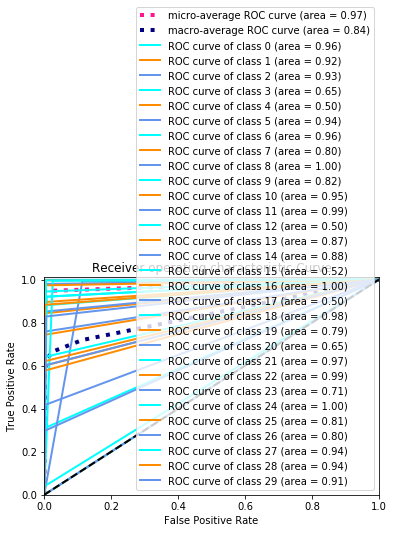

In [198]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
dt_expected = y_test
# y_prob = ovr.predict_proba(X_test)
n_classes = y_test.shape[1]
#  Compute ROC curve and ROC area for each class
# dt_expected_new = label_binarize(dt_expected, classes = pd.Series(y).unique())
# dt_predicted_new = label_binarize(dt_predicted, classes = pd.Series(y).unique())

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot of a ROC curve for a specific class
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [199]:
roc_auc["macro"]

0.8385431050317881

In [200]:
roc_auc["micro"]

0.9720998741326117